# Halo to Halo transfer

This example detail a procedure to compute Halo to Halo transfers in the Earth-Moon CRTBP.


## Configuration

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import r3bpy
from r3bpy.main import Problem, Manifold
import r3bpy.core as constants
from r3bpy.visu import plot_system
from r3bpy.orbits import HaloOrbit, HaloOrbitFamily, print_info

Let's import the usual modules.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## System definition

We now defined the restricted three body problem parameters.

In [4]:
m1 = constants.MU_EARTH
r12 = constants.DISTANCE_EARTH_MOON
m2 = constants.MU_MOON
problem = Problem(m1, m2, r12)
mu_ratio = problem.get_mu_ratio()
DU = problem.get_distance_normalisation()
TU = problem.get_time_normalisation()  

We would now compute and plot the Libration points of this system, as well as a Halo orbit. The purpose would be to evaluate the possibility of a vantage point from the Halo orbit on both asteroids.

## Halo orbits

In [5]:
libration_point1 = problem.get_libration_point_info(r3bpy.main.L1)
libration_point2 = problem.get_libration_point_info(r3bpy.main.L2)

We construct two Halo orbits around L1 and L2

In [6]:
# amplitude of the departure Halo orbit
Ax = 2000e3 / DU
halo = HaloOrbit(libration_point1, HaloOrbitFamily.NORTHERN)
halo_departure = halo.find_orbit(Ax)
orbit_period_dep = halo_departure.period
print_info(halo_departure)
print("Orbit amplitudes: ", halo_departure.Ax, halo_departure.Ay, halo_departure.Az)

Orbit type           : halo
      period         : 2.743204
      Libration Point: L1
      Primaries      :  
Orbit amplitudes:  0.015523253042452358 0.0 0.005185484790973108


In [8]:
_, xyz_halo_dep = halo_departure.propagate([0, orbit_period_dep])  
xyz_halo_dep = np.array(xyz_halo_dep)

In [9]:
# amplitude of the departure Halo orbit
Ax = 2000e3 / DU
halo = HaloOrbit(libration_point2, HaloOrbitFamily.SOUTHERN)
halo_arrival = halo.find_orbit(Ax)
orbit_period_arr = halo_arrival.period
print_info(halo_arrival)
print("Orbit amplitudes: ", halo_arrival.Ax, halo_arrival.Ay, halo_arrival.Az)

Orbit type           : halo
      period         : 3.415210
      Libration Point: L2
      Primaries      :  
Orbit amplitudes:  0.02979978489185494 0.0 0.005185484790973108


In [10]:
_, xyz_halo_arr = halo_arrival.propagate([0, orbit_period_arr])  
xyz_halo_arr = np.array(xyz_halo_arr)

Let's plot these orbits

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

<Figure size 720x720 with 0 Axes>

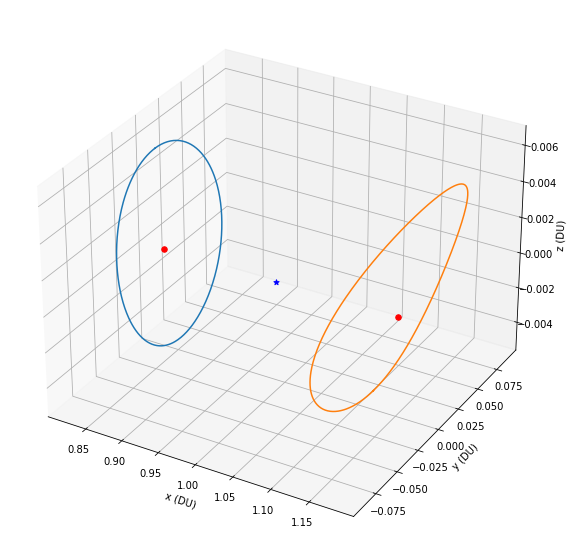

In [11]:
#%matplotlib widget
from r3bpy.visu import plot_trajectory

fig = plt.figure()
ax = plot_system(problem, is2d=False, primaryList=[2], withTriangularPoints=False, colinearPointsList=[1,2])
plot_trajectory(xyz_halo_dep, ax=ax)
plot_trajectory(xyz_halo_arr, ax=ax)

## Simple Low-Thrust Transfer

Now that we have defined initial and arrival orbits, we can compute the best transfer to go from halo_departure to halo_arrival. This transfer is a low-thrust transfer.

In [12]:
from r3bpy.main import ThrusterData, LowThrustProblem, LowThrustPropagator, R3bpOptimalGuidance

Consider a spacecraft of mass 1500 kg, 0.5 N of thrust and 1200s of specific impulse. These parameters have to be normalised with the problem constants.

In [13]:
VU = DU / TU
MU = 1500. # kg
FU = MU * DU / (TU * TU)
thrust = 0.5
isp = 1200.0
eps = ThrusterData(thrust=thrust/FU, isp=isp/VU)
init_mass = 1500.

In [14]:
ltprb = LowThrustProblem(mu_ratio, eps)

Let's instanciate also the lowthrust propagator that is used to propagate both state and costate vectors.

In [15]:
lt_propagator = LowThrustPropagator(mu_ratio, eps)
lt_propagator.set_tol(1e-10, 1e-10)  

The minimum time low thrust transfer is caracterised with initial and final points. We can pick random points along the Lissajous orbits, however, it is likely specific points allow a global minimum of the transfer time.

We discretize the halo orbit into 20 segments, and pick on discrete point for each Halo.

In [16]:
IDX_HALO_PT = 1 # select the point on the initial Halo
_, xyz_halo_discrete_0 = halo_departure.propagate([0, orbit_period_dep], orbit_period_dep / 20) 
x0 = list(xyz_halo_discrete_0[IDX_HALO_PT])
x0[6] = init_mass / MU

Same for the target point

In [17]:
IDX_HALO_PT = 5 # select the point on the final Halo
_, xyz_halo_discrete_f = halo_arrival.propagate([0, orbit_period_arr], orbit_period_arr / 20) 
target_xf = list(xyz_halo_discrete_f[IDX_HALO_PT])

Now, we will use scipy to solve our transfer problem. We need to define the set of constraints for the transfer problem. The LowThrustPropagator will be used to propagate both the state and costate, which allow evaluation the necessary conditions of optimality of the optimal control problem.
These constraints are given by:
- the state constraints
- the transversality conditions

Thus, func defines the set of constraints, while dfunc defines the jacobian of the constraints with respect to the unknown vector (i.e. initial costate vector).

In [18]:
from scipy.optimize import fsolve, leastsq

In [19]:
def func(x, lt_propagator, x0, tof, xf):
    lmd = x[0:7]
    dt = x[6]
    _, ltx, ltl = lt_propagator.propagate(x0, list(lmd), [0.,  tof + dt], -1)
    ltx = np.array(ltx[-1])    
    err = ltx[0:6] - xf[0:6]
    err = list(err)
    ham_tf = 0 #np.dot(ltp[0:6], ltp[7:13]) - 1
    err.append(ham_tf)
    return np.array(err)
                

def dfunc(x, lt_propagator, x0, tof, xf):
    """Jacobian [dx/dlambda, dx/dt]"""
    lmd = list(x[0:7])
    dt = x[6]
    stm = lt_propagator.propagate_stm(x0, lmd, [0.,  tof + dt], -1)

    _, ltx, ltl = lt_propagator.propagate(x0, lmd, [0.,  tof + dt], -1)
    dt_dt = lt_propagator.time_derivative(ltx[-1], ltl[-1])
    
    jac = stm[0:7, 7:14]
    jac[0:7, 6] = dt_dt[0:7] # dx/dt
    return jac

We need to select a initial guess for the solver. It is comprised of 5 costate variables and a variable on the time of flight.

In [20]:
dt = 0.5 * 86400. / TU
lambda0 = [-0.3, -0.2, 0.01, -0.03, -0.4, -0.05, dt] 

We also provide a guess and the time of flight. It will be adjusted during the optimization with dt=lambda[6]

In [21]:
tof = 9. * 86400. / TU

We can now call the solver to solve optimal control problem formulated as a Two-Point Boundary Value Problem:

In [22]:
lambdas, _, info, mesg, ier = leastsq(func, lambda0, Dfun=dfunc, 
                                            args=(lt_propagator, x0, tof, target_xf), 
                                            maxfev=2000, epsfcn=1e-7, factor=0.1, full_output=True) 
print(mesg)
print(info['fvec'])

Number of calls to function has reached maxfev = 2000.
[-1.11578066e-04 -5.64637973e-05  1.71170502e-06  4.17643992e-05
 -1.70618607e-05 -2.95588392e-06  0.00000000e+00]


The output message does not say we have converged, but is the error acceptable?

In [23]:
print("lambdas: {}".format(lambdas[0:6]))
dt = lambdas[6]
print("Time of flight correction: {} ({} days)".format(dt, dt * TU / 86400.))
print("Time of flight: {}  days".format((tof + dt) * TU / 86400.))

lambdas: [-1.29311150e+68 -4.39297701e+67  1.55797286e+67 -4.52244093e+67
 -2.10666249e+67 -2.55855467e+66]
Time of flight correction: -0.010854324885337656 (-0.04737252246521783 days)
Time of flight: 8.952627477534783  days




We have then to use the propagated solution points xyz_halo_dep and xyz_halo_arr.

In [24]:
t, ltx, ltl = lt_propagator.propagate(x0, list(lambdas), [0.,  tof + dt], -1)   
ltx = np.array(ltx)  
ltl = np.array(ltl)  

To compute the thrust direction for any point, 

In [25]:
guidance = lt_propagator.get_guidance()
u = guidance.control_direction(ltx[1::30], ltl[1::30])
u = np.array(u)

Let's plot the transfer

<Figure size 720x720 with 0 Axes>

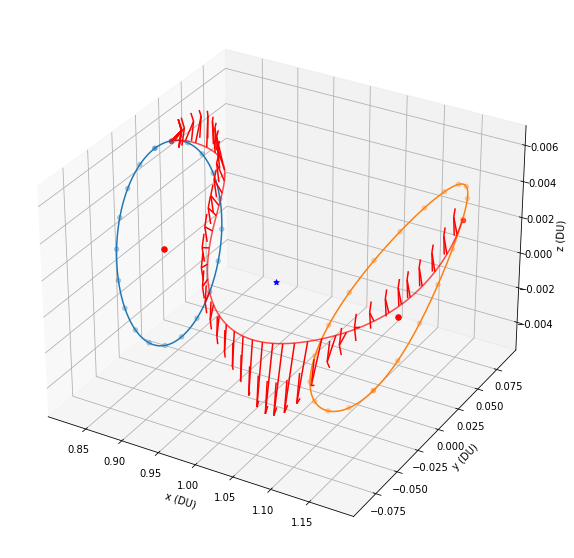

In [26]:
#%matplotlib widget
from r3bpy.visu import plot_trajectory
xyz_halo_discrete_0 = np.array(xyz_halo_discrete_0)
xyz_halo_discrete_f = np.array(xyz_halo_discrete_f)

fig = plt.figure()
ax = plot_system(problem, is2d=False, primaryList=[2], withTriangularPoints=False, colinearPointsList=[1,2])
plot_trajectory(xyz_halo_dep, ax=ax) # departure Halo
plot_trajectory(xyz_halo_arr, ax=ax) # arrival Halo
ax.scatter(x0[0], x0[1], x0[2], color='red', alpha=0.7) # departure point
ax.scatter(target_xf[0], target_xf[1], target_xf[2], color='red', alpha=0.7) # arrival point
ax.scatter(xyz_halo_discrete_0[:,0], xyz_halo_discrete_0[:,1], xyz_halo_discrete_0[:,2], alpha=0.3) # departure candidates
ax.scatter(xyz_halo_discrete_f[:,0], xyz_halo_discrete_f[:,1], xyz_halo_discrete_f[:,2], alpha=0.3) # arrival candidates

plot_trajectory(ltx, ax=ax, color='red', alpha=0.7, legend='Low thrust transfer')
ax.quiver(ltx[1::30][:,0], ltx[1::30][:,1], ltx[1::30][:,2], u[:,0], u[:,1], u[:,2], length=1e-2, normalize=True, color='red')# draw thrust direction 


The approch of using an indirect method ensures the trajectory is physical, we may just miss a bit the target accordingly with the result of the optimisation. 
In those cases, and in particular with indirect optimal control methods, to increase accuracy (and numerical robusteness), it is good to split the transfer in parts.

## Multiple-shooting Low-thrust transfer

We are going to split the transfer in two parts. We will not currently seek to construct a transfer with a heteroclinic connection. Rather, we will look for a transfer in minimum time:

- The first part concerns the transfer around L1 that leaves the Halo orbit and reach a mid-point between the Halos.
- The second part concerns the transfer around L2 that arrives at the Halo from a mid-point between the Halos.

In [27]:
def func_ms(x, lt_propagator, x0, tof, xf):
    lmd_0 = list(x[0:7])   
    lmd_0[6] = 1.
    lmd_mid = list(x[6:13])
    lmd_mid[6] = 1
    xmid = list(x[12:19])
    dt = x[18]        
    
    _, lt_x1, lt_l1 = lt_propagator.propagate(x0, lmd_0, [0.,  tof/2], -1)
    lt_x1 = np.array(lt_x1[-1])    
    lt_l1 = np.array(lt_l1[-1])    

    xmid[6] = lt_x1[6] # mass continuity
    _, lt_x2, lt_l2 = lt_propagator.propagate(xmid, lmd_mid, [0.,  tof/2 + dt], -1)        
    lt_x2 = np.array(lt_x2[-1])    
    
    err1 = lt_x1[0:6] - xmid[0:6] # state patch constraint
    err2 = lt_l1[0:6] - lmd_mid[0:6] # costate patch constraint
    err3 = lt_x2[0:6] - xf[0:6] # final target            
    ham_tf = 0 #np.dot(ltp[0:6], ltp[7:13]) - 1
    
    err = list(err1) + list(err2) + list(err3)
    err.append(ham_tf)    
    return np.array(err)
                

def dfunc_ms(x, lt_propagator, x0, tof, xf):
    """Jacobian [dx/dlambda, dx/dt]"""
    lmd_0 = list(x[0:7])   
    lmd_0[6] = 1.
    lmd_mid = list(x[6:13])
    lmd_mid[6] = 1
    xmid = list(x[12:19])
    dt = x[18]      
    
    _, lt_x1, lt_l1 = lt_propagator.propagate(x0, lmd_0, [0.,  tof/2], -1)
    lt_x1 = np.array(lt_x1[-1])  
    lt_l1 = np.array(lt_l1[-1])  
    stm1 = lt_propagator.propagate_stm(x0, lmd_0, [0.,  tof/2], -1)
    
    xmid[6] = lt_x1[6] # mass continuity    
    stm2 = lt_propagator.propagate_stm(xmid, lmd_mid, [0.,  tof/2 + dt], -1)
    
    _, ltx, ltl = lt_propagator.propagate(xmid, lmd_mid, [0.,  tof/2 + dt], -1)
    dt_dt = lt_propagator.time_derivative(ltx[-1], ltl[-1])
    
    jac = np.zeros((19, 19))
    jac[0:6, 0:6] = stm1[0:6, 7:13]  # derr1/dlambda
    jac[0:6, 12:18] =-np.eye(6)  # derr1/dx_mid
    jac[6:12, 0:6] = stm1[7:13, 7:13] # derr2/dlambda
    jac[6:12, 6:12] =-np.eye(6)  # derr2/dlambda_mid
    jac[12:18, 6:12] = stm2[0:6, 7:13] # derr3/dlambda_mid
    jac[12:18, 12:18] = stm2[0:6, 0:6]  # derr3/dx_mid    
    jac[12:18, 18] = dt_dt[0:6] # dx/dt
    
    return jac

Finding a good initial guess is the tricky part. This is owing to the indirect method. However, splitting the trajectory in two or multiple parts generally helps by splitting sensitivuty of the costate into the segments.

The initial unknown vector is decomposed into:
- initial costate vector for the first segment
- initial costate vector for the second segment
- patch state vector / initial state vector for the second segment
- time correction

In [28]:
tof = 9. * 86400. / TU
dt = 0.2 * 86400. / TU
lambda_init = [-0.93, -0.02, 0.004, -0.3, -0.07, -0.03]
lambda_mid_point = [-0.8, -0.3, 0.15, 0.1, 0.05, 0.02]
x_mid_point = [0.965, -0.05, 0.001, 0.54, -0.1, -0.005]
# xinitguess = [lambda_0[6], x_mid_point[6], dt[1]]
xinitguess = lambda_init + lambda_mid_point + x_mid_point + [dt]

We try to solve it with two solvers. Again, leastsq performs a bit better, but this is initial guess dependent.

In [29]:
xsol, info, ier, mesg = fsolve(func_ms, xinitguess, fprime=dfunc_ms, 
                                            args=(lt_propagator, x0, tof, target_xf), 
                                            maxfev=1000, epsfcn=1e-9, factor=0.1, full_output=True) 
#xsol=xinitguess
xsol, _, info, mesg, ier = leastsq(func_ms, xsol, Dfun=dfunc_ms, 
                                            args=(lt_propagator, x0, tof, target_xf), 
                                            maxfev=1000, epsfcn=1e-9, factor=0.1, full_output=True) 
print(mesg)
print(info['fvec'])

The relative error between two consecutive iterates is at most 0.000000
[ 1.03250741e-14 -2.15105711e-16 -2.22405441e-16  5.85087534e-14
  5.50948176e-14 -5.42968448e-16 -4.29156710e-13  2.64677169e-13
  1.65978342e-14 -2.81719092e-14 -4.21052082e-14  4.00027234e-15
 -4.24105195e-14  1.11577414e-14  1.08767162e-15 -9.08231823e-14
  1.73732556e-14  4.49293380e-16  0.00000000e+00]


Decomposing the error vector shows the improved accuracy on the rendezvous error.

In [30]:
print("State patch point error: ", info['fvec'][0:6])
print("Costate patch point error: ", info['fvec'][7:13])
print("Final point rendezvous error: ", info['fvec'][12:18])

State patch point error:  [ 1.03250741e-14 -2.15105711e-16 -2.22405441e-16  5.85087534e-14
  5.50948176e-14 -5.42968448e-16]
Costate patch point error:  [ 2.64677169e-13  1.65978342e-14 -2.81719092e-14 -4.21052082e-14
  4.00027234e-15 -4.24105195e-14]
Final point rendezvous error:  [-4.24105195e-14  1.11577414e-14  1.08767162e-15 -9.08231823e-14
  1.73732556e-14  4.49293380e-16]


And optimization result in details

In [31]:
lambda_init = list(xsol[0:7])
lambda_mid = list(xsol[6:13])
x_mid = list(xsol[12:19])
dt = xsol[18]  
print("xsol: {}".format(xsol))
print('lambda init: ', lambda_init[0:6])
print('Mid point: ', x_mid[0:6])
print('lambda point: ', lambda_mid)
print("Time of flight correction: {} ({} days)".format(dt, dt * TU / 86400.))
print("Time of flight: {}  days".format((tof + dt) * TU / 86400.))

xsol: [-1.44917630e+00 -4.98351115e-01  1.75824399e-01 -5.07499177e-01
 -2.36279022e-01 -2.86364332e-02 -2.97402492e-01  2.84815362e+00
 -2.60159363e-01 -1.83601867e-01  2.44397010e-01  1.91334338e-02
  9.63841627e-01 -4.62163068e-02 -1.42017909e-05  5.11305033e-01
 -1.41465621e-01 -1.25945774e-02 -7.07548131e-03]
lambda init:  [-1.4491762979418994, -0.4983511148426007, 0.17582439916852546, -0.5074991766014118, -0.23627902229245282, -0.0286364331663291]
Mid point:  [0.9638416271519316, -0.046216306819909986, -1.4201790859864027e-05, 0.511305032958192, -0.1414656214124891, -0.012594577404784238]
lambda point:  [-0.29740249230076293, 2.8481536209929894, -0.26015936339517737, -0.18360186680672957, 0.2443970095218558, 0.019133433836696537, 0.9638416271519316]
Time of flight correction: -0.007075481306450674 (-0.030880169949108395 days)
Time of flight: 8.969119830050891  days


 We can propagate the two segments independantly.

In [32]:
t1, ltx1, ltl1 = lt_propagator.propagate(x0, lambda_init, [0.,  tof/2], -1)   
ltx1 = np.array(ltx1)  
ltl1 = np.array(ltl1) 
print('Mid point:', ltx1[-1])

Mid point: [ 9.63841627e-01 -4.62163068e-02 -1.42017909e-05  5.11305033e-01
 -1.41465621e-01 -1.25945774e-02  2.03107159e+00]


In [33]:
patch_point = list(ltx1[-1])
x_mid[6] = patch_point[6] 
t2, ltx2, ltl2 = lt_propagator.propagate(x_mid, lambda_mid, [0.,  tof/2 + dt], -1)   
ltx2 = np.array(ltx2)  
ltl2 = np.array(ltl2) 

We can now plot the complete trajectory.

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

<Figure size 720x720 with 0 Axes>

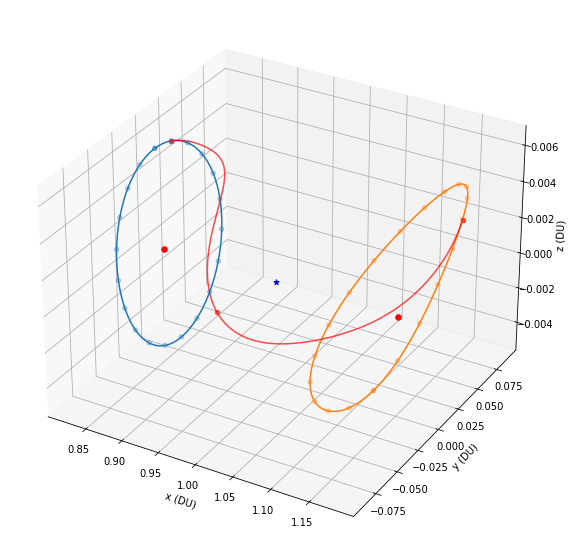

In [34]:
#%matplotlib widget
from r3bpy.visu import plot_trajectory
xyz_halo_discrete_0 = np.array(xyz_halo_discrete_0)
xyz_halo_discrete_f = np.array(xyz_halo_discrete_f)

fig = plt.figure()
ax = plot_system(problem, is2d=False, primaryList=[2], withTriangularPoints=False, colinearPointsList=[1,2])
plot_trajectory(xyz_halo_dep, ax=ax) # departure Halo
plot_trajectory(xyz_halo_arr, ax=ax) # arrival Halo
ax.scatter(x0[0], x0[1], x0[2], color='red', alpha=0.7) # departure point
ax.scatter(target_xf[0], target_xf[1], target_xf[2], color='red', alpha=0.7) # arrival point
ax.scatter(xyz_halo_discrete_0[:,0], xyz_halo_discrete_0[:,1], xyz_halo_discrete_0[:,2], alpha=0.3) # departure candidates
ax.scatter(xyz_halo_discrete_f[:,0], xyz_halo_discrete_f[:,1], xyz_halo_discrete_f[:,2], alpha=0.3) # arrival candidates

ax.scatter(x_mid[0], x_mid[1], x_mid[2], alpha=0.5, color='red') # patch point

plot_trajectory(ltx1, ax=ax, color='red', alpha=0.7, legend='Low thrust transfer')
plot_trajectory(ltx2, ax=ax, color='red', alpha=0.7)

So, we printed before the patch point error, which was acceptable, and we can confirm graphically the continuity between the two segments. The patch point is plotted as the red dot in the middle.

In addition, the rendezvous condition is also satisfied.

voilà!